In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from sklego.linear_model import LowessRegression
import numpy as np
from scipy.interpolate import UnivariateSpline
import seaborn as sns

In [2]:
# load metadata
metadata = pd.read_csv("/Users/dagmarschierova/MEGA/MBÚ/TNF/NGS/runs_merged/inputs/metadata_stool.tsv", sep='\t')
metadata = metadata.iloc[1:]
metadata.set_index('#SampleID', inplace=True)
metadata

,Label,Plate,Position,Patient,Age,Sex,Height,Weight,BMI,BMI_category,...,Response_scale3_Start_end,Dg_Response_scale2_Start_end,Disease_severity_scale2_Start_end,Disease_severity_scale4_Start_end,Response_scale2_Start_end_combined,Response_scale3_Start_end_combined,Dg_Response_scale2_Start_end_combined,Disease_severity_scale2_Start_end_combined,Disease_severity_scale4_Start_end_combined,Dg_Week38
#SampleID,,,,,,,,,,,,,,,,,,,,,
1_BA_1,1_BA_1,B1,A1,P1,25,F,170,77,26.6,overweight,...,baseline_start,CD_no_response_start,inactive_start,mild_start,no_response_start,baseline_start,CD_no_response_start,inactive_start,mild_start,CD_week_0
1_BA_2,1_BA_2,B1,B1,P1,25,F,170,77,26.6,overweight,...,full_response_NA,CD_response_NA,inactive_NA,remission_NA,response_NA,full_response_NA,CD_response_NA,inactive_NA,remission_NA,CD_week_2
1_BA_3,1_BA_3,B1,C1,P1,25,F,170,78,27,overweight,...,full_response_NA,CD_response_NA,inactive_NA,remission_NA,response_NA,full_response_NA,CD_response_NA,inactive_NA,remission_NA,CD_week_8
1_BA_4,1_BA_4,B1,D1,P1,25,F,170,79,27.3,overweight,...,full_response_NA,CD_response_NA,inactive_NA,remission_NA,response_NA,full_response_NA,CD_response_NA,inactive_NA,remission_NA,CD_week_14
1_BA_5,1_BA_5,B1,E1,P1,25,F,170,80,27.7,overweight,...,full_response_NA,CD_response_NA,inactive_NA,remission_NA,response_NA,full_response_NA,CD_response_NA,inactive_NA,remission_NA,CD_week_22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mock_4_DNA,mock_4_DNA,B2,B12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21_PP_8_ADA,21_PP_8_ADA,B2,E12,P21_ADA,25,F,165,64,23.5,normal,...,NaN,CD_NA,NaN,NaN,NaN,NaN,CD_NA,NaN,NaN,CD_NA
P72_DM_7,P72_DM_7,B2,F12,P72,34,F,175,56,18.3,underweight,...,full_response_end,CD_response_end,inactive_end,remission_end,response_end,full_response_end,CD_response_end,inactive_end,remission_end,CD_week_38


In [3]:
# load shannon diversity values
shannon = pd.read_csv("/Users/dagmarschierova/MEGA/MBÚ/TNF/NGS/runs_merged/outputs/qiime_results_B/diversity_Large_cohort/alpha/shannon.tsv", sep='\t')
shannon = shannon.iloc[1:]
shannon.set_index('SampleID', inplace=True)
shannon

,Shannon_entropy
SampleID,
1_BA_1,5.245601555
1_BA_2,5.328261504
1_BA_3,5.230081928
1_BA_4,4.206164775
1_BA_5,4.908037192
...,...
P78_BL_8,6.070990062
P79_MM_1,5.613115942
P80_KA_1,5.015685951


In [4]:
# merge shannon with metadata
metadata = metadata.merge(shannon, how='inner', left_index=True, right_index=True)
metadata

,Label,Plate,Position,Patient,Age,Sex,Height,Weight,BMI,BMI_category,...,Dg_Response_scale2_Start_end,Disease_severity_scale2_Start_end,Disease_severity_scale4_Start_end,Response_scale2_Start_end_combined,Response_scale3_Start_end_combined,Dg_Response_scale2_Start_end_combined,Disease_severity_scale2_Start_end_combined,Disease_severity_scale4_Start_end_combined,Dg_Week38,Shannon_entropy
1_BA_1,1_BA_1,B1,A1,P1,25,F,170,77,26.6,overweight,...,CD_no_response_start,inactive_start,mild_start,no_response_start,baseline_start,CD_no_response_start,inactive_start,mild_start,CD_week_0,5.245601555
1_BA_2,1_BA_2,B1,B1,P1,25,F,170,77,26.6,overweight,...,CD_response_NA,inactive_NA,remission_NA,response_NA,full_response_NA,CD_response_NA,inactive_NA,remission_NA,CD_week_2,5.328261504
1_BA_3,1_BA_3,B1,C1,P1,25,F,170,78,27,overweight,...,CD_response_NA,inactive_NA,remission_NA,response_NA,full_response_NA,CD_response_NA,inactive_NA,remission_NA,CD_week_8,5.230081928
1_BA_4,1_BA_4,B1,D1,P1,25,F,170,79,27.3,overweight,...,CD_response_NA,inactive_NA,remission_NA,response_NA,full_response_NA,CD_response_NA,inactive_NA,remission_NA,CD_week_14,4.206164775
1_BA_5,1_BA_5,B1,E1,P1,25,F,170,80,27.7,overweight,...,CD_response_NA,inactive_NA,remission_NA,response_NA,full_response_NA,CD_response_NA,inactive_NA,remission_NA,CD_week_22,4.908037192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K22_1,K22_1,B2,G11,HC22,51,F,161,76,29.3,overweight,...,HC,HC,HC,HC,HC,HC,HC,HC,HC,6.629727629
K23_1,K23_1,B2,H11,HC23,33,M,186,95,27.5,overweight,...,HC,HC,HC,HC,HC,HC,HC,HC,HC,5.403106622
P72_DM_7,P72_DM_7,B2,F12,P72,34,F,175,56,18.3,underweight,...,CD_response_end,inactive_end,remission_end,response_end,full_response_end,CD_response_end,inactive_end,remission_end,CD_week_38,6.279090304
P53_CZ_8,P53_CZ_8,B2,G12,P53,41,F,160,74,28.9,overweight,...,CD_response_end,inactive_end,mild_end,response_end,partial_response_end,CD_response_end,inactive_end,mild_end,CD_week_46,6.446036159


In [5]:
convert_dict = {'Week_num': float,
                'Visit_num': float,
                'HBI_num': float,
                'pMayo_num': float,
                'Shannon_entropy': float
               }
  
metadata = metadata.astype(convert_dict)
print(metadata.dtypes)

Label                                          object
Plate                                          object
Position                                       object
Patient                                        object
Age                                            object
                                               ...   
Dg_Response_scale2_Start_end_combined          object
Disease_severity_scale2_Start_end_combined     object
Disease_severity_scale4_Start_end_combined     object
Dg_Week38                                      object
Shannon_entropy                               float64
Length: 133, dtype: object


In [6]:
# filter out CD patients only
cd = metadata[(metadata['Dg']=='CD') & (-metadata["Label"].isin(['P53_CZ_8','P71_SJ_9']))]
cd_l1 = cd[cd['CD_localisation']=='L1']
cd_l2 = cd[cd['CD_localisation']=='L2']
cd_l3 = cd[cd['CD_localisation']=='L3']
cd_ifx = cd[cd['Drug']=='IFX']
cd_ada = cd[cd['Drug']=='ADA']
cd_bsln = cd[(cd['Week']=='week_0') & (-cd["Label"].isin(['1_BA_1','21_PP_7_IFX_1_ADA','28_WL_1_IFX','45_SK_1']))]


In [7]:
# filter out UC patients only
uc = metadata[metadata['Dg']=='UC']
uc_e1 = uc[uc['UC_extent']=='E1']
uc_e2 = uc[uc['UC_extent']=='E2']
uc_e3 = uc[uc['UC_extent']=='E3']
uc_ifx = uc[uc['Drug']=='IFX']
uc_ada = uc[uc['Drug']=='ADA']
uc_bsln = uc[(uc['Week']=='week_0') & (-uc["Label"].isin(['1_BA_1','21_PP_7_IFX_1_ADA','28_WL_1_IFX']))]


In [8]:
# filter out HC only
hc = metadata[(metadata['Dg']=='HC') & (-metadata["Label"].isin(['K9_Z80_1','K11_M87_1','K20_Z76_1']))]

## Create plots with localisation subgroups - lowess

In [9]:
# create a dictionary having individual patients as keys for CD of different localisations
patients_cd_l1 = dict()
for individual in cd_l1['Patient'].unique():
    patients_cd_l1[individual] = cd_l1[(cd_l1['Patient'] == individual)][["Week_num","HBI_num","Shannon_entropy","CD_localisation"]]

patients_cd_l2 = dict()
for individual in cd_l2['Patient'].unique():
    patients_cd_l2[individual] = cd_l2[(cd_l2['Patient'] == individual)][["Week_num","HBI_num","Shannon_entropy","CD_localisation"]]

patients_cd_l3 = dict()
for individual in cd_l3['Patient'].unique():
    patients_cd_l3[individual] = cd_l3[(cd_l3['Patient'] == individual)][["Week_num","HBI_num","Shannon_entropy","CD_localisation"]]

# create a dictionary having individual patients as keys for UC of different localisations
patients_uc_e1 = dict()
for individual in uc_e1['Patient'].unique():
    patients_uc_e1[individual] = uc_e1[(uc_e1['Patient'] == individual)][["Week_num","pMayo_num","Shannon_entropy","UC_extent"]]

patients_uc_e2 = dict()
for individual in uc_e2['Patient'].unique():
    patients_uc_e2[individual] = uc_e2[(uc_e2['Patient'] == individual)][["Week_num","pMayo_num","Shannon_entropy","UC_extent"]]

patients_uc_e3 = dict()
for individual in uc_e3['Patient'].unique():
    patients_uc_e3[individual] = uc_e3[(uc_e3['Patient'] == individual)][["Week_num","pMayo_num","Shannon_entropy","UC_extent"]]

In [10]:
# sort the values according to week number and drop NA
for individual in patients_cd_l1.keys():
    patients_cd_l1[individual].sort_values('Week_num', inplace=True)
    patients_cd_l1[individual].dropna(inplace=True)
    
for individual in patients_cd_l2.keys():
    patients_cd_l2[individual].sort_values('Week_num', inplace=True)
    patients_cd_l2[individual].dropna(inplace=True)
    
for individual in patients_cd_l3.keys():
    patients_cd_l3[individual].sort_values('Week_num', inplace=True)
    patients_cd_l3[individual].dropna(inplace=True)
    
for individual in patients_uc_e1.keys():
    patients_uc_e1[individual].sort_values('Week_num', inplace=True)
    patients_uc_e1[individual].dropna(inplace=True)
    
for individual in patients_uc_e2.keys():
    patients_uc_e2[individual].sort_values('Week_num', inplace=True)
    patients_uc_e2[individual].dropna(inplace=True)
    
for individual in patients_uc_e3.keys():
    patients_uc_e3[individual].sort_values('Week_num', inplace=True)
    patients_uc_e3[individual].dropna(inplace=True)

In [11]:
cd_l1_lowess = cd_l1[['HBI_num','Shannon_entropy','Week_num']].dropna()
cd_l2_lowess = cd_l2[['HBI_num','Shannon_entropy','Week_num']].dropna()
cd_l3_lowess = cd_l3[['HBI_num','Shannon_entropy','Week_num']].dropna()

uc_e1_lowess = uc_e1[['pMayo_num','Shannon_entropy','Week_num']].dropna()
uc_e2_lowess = uc_e2[['pMayo_num','Shannon_entropy','Week_num']].dropna()
uc_e3_lowess = uc_e3[['pMayo_num','Shannon_entropy','Week_num']].dropna()

#### Model for HBI lowess

In [12]:
# create a reg model
Xl1 = cd_l1_lowess['Week_num'].to_numpy().reshape(-1,1)
Xl2 = cd_l2_lowess['Week_num'].to_numpy().reshape(-1,1)
Xl3 = cd_l3_lowess['Week_num'].to_numpy().reshape(-1,1)
yl1 = cd_l1_lowess['HBI_num'].to_numpy()
yl2 = cd_l2_lowess['HBI_num'].to_numpy()
yl3 = cd_l3_lowess['HBI_num'].to_numpy()
mod_l1 = LowessRegression(sigma=10).fit(Xl1, yl1)
mod_l2 = LowessRegression(sigma=10).fit(Xl2, yl2)
mod_l3 = LowessRegression(sigma=10).fit(Xl3, yl3)

# predict with the model
x_pred = np.array([0,2,6,8,14,20,22,26,30,32,38]).reshape(-1, 1)
#x_pred = np.arange(start=0, stop=38.5, step=2).reshape(-1, 1)
y_pred_l1 = mod_l1.predict(x_pred)
y_pred_l2 = mod_l2.predict(x_pred)
y_pred_l3 = mod_l3.predict(x_pred)
y_pred_l1 = pd.DataFrame(y_pred_l1).rename(columns={0: "HBI_pred_lowess"})
y_pred_l2 = pd.DataFrame(y_pred_l2).rename(columns={0: "HBI_pred_lowess"})
y_pred_l3 = pd.DataFrame(y_pred_l3).rename(columns={0: "HBI_pred_lowess"})

# create a df with predicted values
pred_lowess_cd_hbi_l1 = y_pred_l1.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})
pred_lowess_cd_hbi_l2 = y_pred_l2.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})
pred_lowess_cd_hbi_l3 = y_pred_l3.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})

# calculate confidence interval
ci_cd_hbi_l1 = 1.96 * np.std(cd_l1_lowess["HBI_num"])/np.mean(cd_l1_lowess["HBI_num"])
ci_cd_hbi_l2 = 1.96 * np.std(cd_l2_lowess["HBI_num"])/np.mean(cd_l2_lowess["HBI_num"])
ci_cd_hbi_l3 = 1.96 * np.std(cd_l3_lowess["HBI_num"])/np.mean(cd_l3_lowess["HBI_num"])

#### Model for pMayo lowess

In [13]:
# create a reg model
Xe1 = uc_e1_lowess['Week_num'].to_numpy().reshape(-1,1)
Xe2 = uc_e2_lowess['Week_num'].to_numpy().reshape(-1,1)
Xe3 = uc_e3_lowess['Week_num'].to_numpy().reshape(-1,1)
ye1 = uc_e1_lowess['pMayo_num'].to_numpy()
ye2 = uc_e2_lowess['pMayo_num'].to_numpy()
ye3 = uc_e3_lowess['pMayo_num'].to_numpy()
mod_e1 = LowessRegression(sigma=10).fit(Xe1, ye1)
mod_e2 = LowessRegression(sigma=10).fit(Xe2, ye2)
mod_e3 = LowessRegression(sigma=10).fit(Xe3, ye3)

# predict with the model
x_pred = np.array([0,2,6,8,14,20,22,26,30,32,38]).reshape(-1, 1)
#x_pred = np.arange(start=0, stop=38.5, step=2).reshape(-1, 1)
y_pred_e1 = mod_e1.predict(x_pred)
y_pred_e2 = mod_e2.predict(x_pred)
y_pred_e3 = mod_e3.predict(x_pred)
y_pred_e1 = pd.DataFrame(y_pred_e1).rename(columns={0: "pMayo_pred_lowess"})
y_pred_e2 = pd.DataFrame(y_pred_e2).rename(columns={0: "pMayo_pred_lowess"})
y_pred_e3 = pd.DataFrame(y_pred_e3).rename(columns={0: "pMayo_pred_lowess"})

# create a df with predicted values
pred_lowess_uc_pmayo_e1 = y_pred_e1.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})
pred_lowess_uc_pmayo_e2 = y_pred_e2.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})
pred_lowess_uc_pmayo_e3 = y_pred_e3.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})

# calculate confidence interval
ci_uc_pmayo_e1 = 1.96 * np.std(uc_e1_lowess["pMayo_num"])/np.mean(uc_e1_lowess["pMayo_num"])
ci_uc_pmayo_e2 = 1.96 * np.std(uc_e2_lowess["pMayo_num"])/np.mean(uc_e2_lowess["pMayo_num"])
ci_uc_pmayo_e3 = 1.96 * np.std(uc_e3_lowess["pMayo_num"])/np.mean(uc_e3_lowess["pMayo_num"])

#### Model for Shannon CD lowess

In [14]:
# create a reg model
Xl1 = cd_l1_lowess['Week_num'].to_numpy().reshape(-1,1)
Xl2 = cd_l2_lowess['Week_num'].to_numpy().reshape(-1,1)
Xl3 = cd_l3_lowess['Week_num'].to_numpy().reshape(-1,1)
yl1 = cd_l1_lowess['Shannon_entropy'].to_numpy()
yl2 = cd_l2_lowess['Shannon_entropy'].to_numpy()
yl3 = cd_l3_lowess['Shannon_entropy'].to_numpy()
mod_l1 = LowessRegression(sigma=10).fit(Xl1, yl1)
mod_l2 = LowessRegression(sigma=10).fit(Xl2, yl2)
mod_l3 = LowessRegression(sigma=10).fit(Xl3, yl3)

# predict with the model
x_pred = np.array([0,2,6,8,14,20,22,26,30,32,38]).reshape(-1, 1)
#x_pred = np.arange(start=0, stop=38.5, step=2).reshape(-1, 1)
y_pred_l1 = mod_l1.predict(x_pred)
y_pred_l2 = mod_l2.predict(x_pred)
y_pred_l3 = mod_l3.predict(x_pred)
y_pred_l1 = pd.DataFrame(y_pred_l1).rename(columns={0: "Shannon_pred_lowess"})
y_pred_l2 = pd.DataFrame(y_pred_l2).rename(columns={0: "Shannon_pred_lowess"})
y_pred_l3 = pd.DataFrame(y_pred_l3).rename(columns={0: "Shannon_pred_lowess"})

# create a df with predicted values
pred_lowess_cd_shannon_l1 = y_pred_l1.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})
pred_lowess_cd_shannon_l2 = y_pred_l2.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})
pred_lowess_cd_shannon_l3 = y_pred_l3.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})

# calculate confidence interval
ci_cd_shannon_l1 = 1.96 * np.std(cd_l1_lowess["Shannon_entropy"])/np.mean(cd_l1_lowess["Shannon_entropy"])
ci_cd_shannon_l2 = 1.96 * np.std(cd_l2_lowess["Shannon_entropy"])/np.mean(cd_l2_lowess["Shannon_entropy"])
ci_cd_shannon_l3 = 1.96 * np.std(cd_l3_lowess["Shannon_entropy"])/np.mean(cd_l3_lowess["Shannon_entropy"])

#### Model for Shannon UC lowess

In [15]:
# create a reg model
Xe1 = uc_e1_lowess['Week_num'].to_numpy().reshape(-1,1)
Xe2 = uc_e2_lowess['Week_num'].to_numpy().reshape(-1,1)
Xe3 = uc_e3_lowess['Week_num'].to_numpy().reshape(-1,1)
ye1 = uc_e1_lowess['Shannon_entropy'].to_numpy()
ye2 = uc_e2_lowess['Shannon_entropy'].to_numpy()
ye3 = uc_e3_lowess['Shannon_entropy'].to_numpy()
mod_e1 = LowessRegression(sigma=10).fit(Xe1, ye1)
mod_e2 = LowessRegression(sigma=10).fit(Xe2, ye2)
mod_e3 = LowessRegression(sigma=10).fit(Xe3, ye3)

# predict with the model
x_pred = np.array([0,2,6,8,14,20,22,26,30,32,38]).reshape(-1, 1)
#x_pred = np.arange(start=0, stop=38.5, step=2).reshape(-1, 1)
y_pred_e1 = mod_e1.predict(x_pred)
y_pred_e2 = mod_e2.predict(x_pred)
y_pred_e3 = mod_e3.predict(x_pred)
y_pred_e1 = pd.DataFrame(y_pred_e1).rename(columns={0: "Shannon_pred_lowess"})
y_pred_e2 = pd.DataFrame(y_pred_e2).rename(columns={0: "Shannon_pred_lowess"})
y_pred_e3 = pd.DataFrame(y_pred_e3).rename(columns={0: "Shannon_pred_lowess"})

# create a df with predicted values
pred_lowess_uc_shannon_e1 = y_pred_e1.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})
pred_lowess_uc_shannon_e2 = y_pred_e2.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})
pred_lowess_uc_shannon_e3 = y_pred_e3.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})

# calculate confidence interval
ci_uc_shannon_e1 = 1.96 * np.std(uc_e1_lowess["Shannon_entropy"])/np.mean(uc_e1_lowess["Shannon_entropy"])
ci_uc_shannon_e2 = 1.96 * np.std(uc_e2_lowess["Shannon_entropy"])/np.mean(uc_e2_lowess["Shannon_entropy"])
ci_uc_shannon_e3 = 1.96 * np.std(uc_e3_lowess["Shannon_entropy"])/np.mean(uc_e3_lowess["Shannon_entropy"])

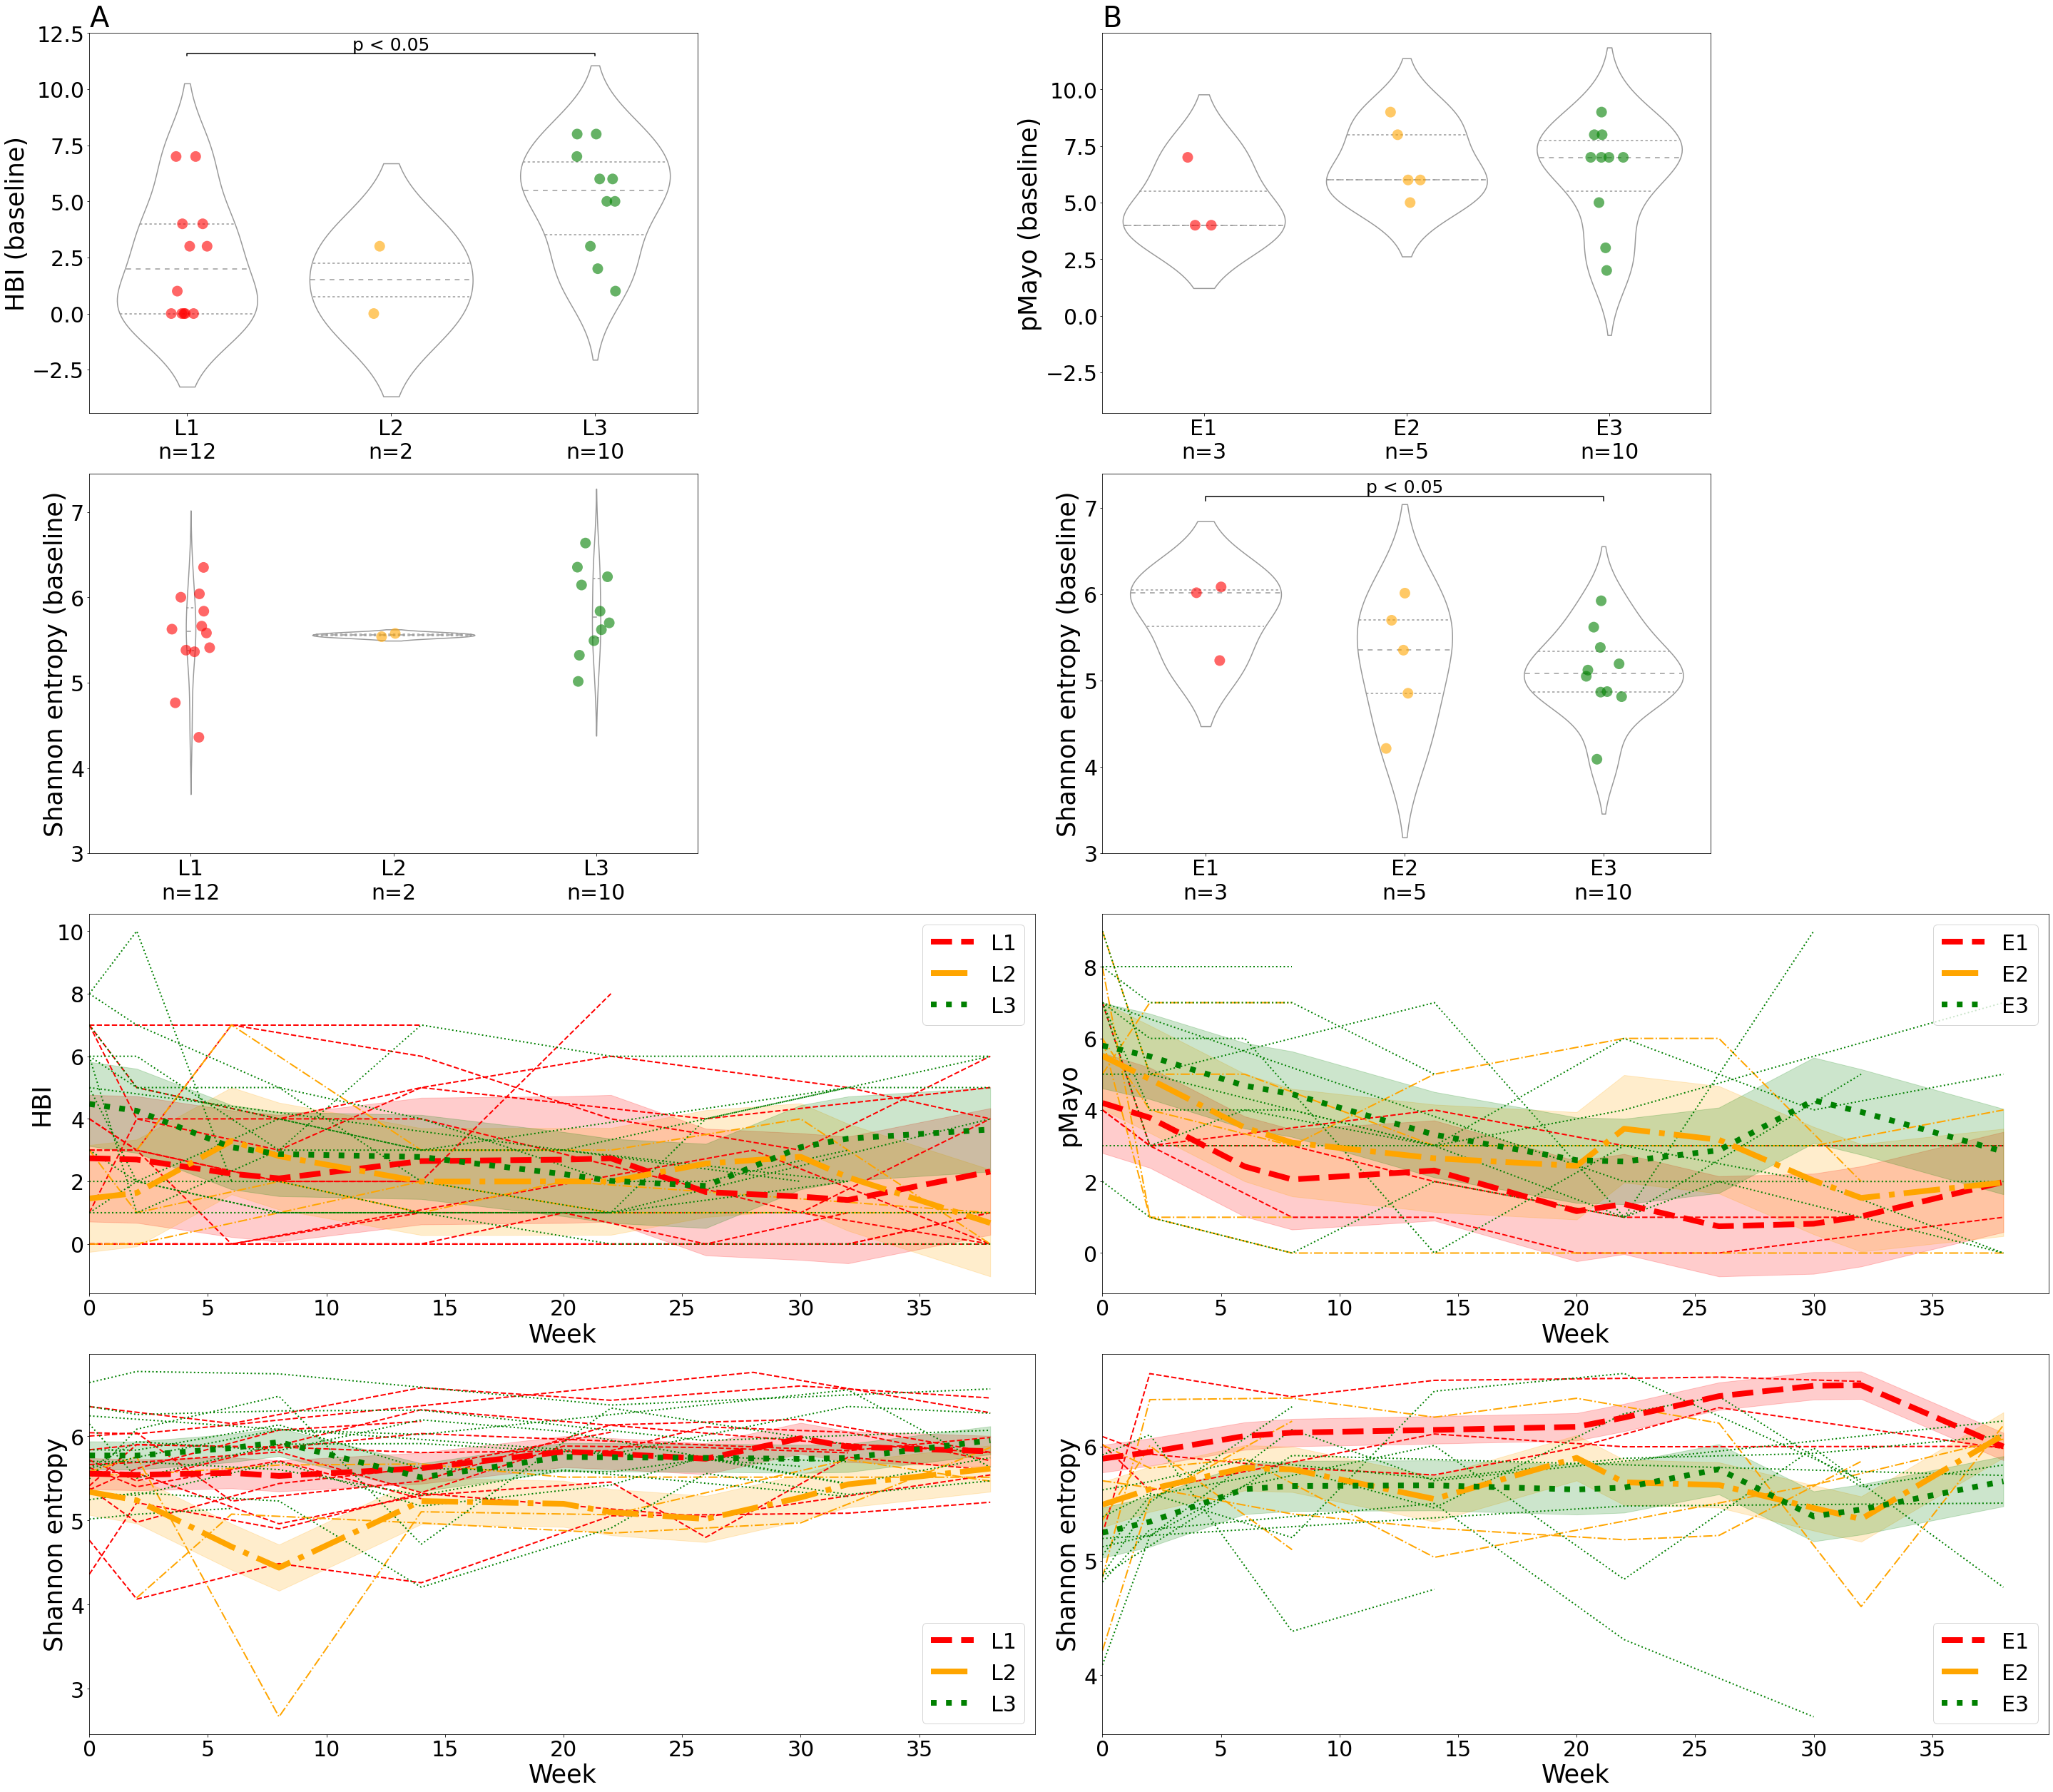

In [16]:
# create grid for subplots
fig1 = plt.figure()
fig1.set_figheight(35)
fig1.set_figwidth(40)
  
ax1 = plt.subplot2grid(shape=(4, 6), loc=(2, 0), colspan=3)
ax2 = plt.subplot2grid(shape=(4, 6), loc=(2, 3), colspan=3)
ax3 = plt.subplot2grid(shape=(4, 6), loc=(3, 0), colspan=3)
ax4 = plt.subplot2grid(shape=(4, 6), loc=(3, 3), colspan=3)
ax5 = plt.subplot2grid(shape=(4, 6), loc=(0, 0), colspan=2)
ax6 = plt.subplot2grid(shape=(4, 6), loc=(0, 3), colspan=2)
ax7 = plt.subplot2grid(shape=(4, 6), loc=(1, 0), colspan=2)
ax8 = plt.subplot2grid(shape=(4, 6), loc=(1, 3), colspan=2)



## timelines ##

# plot all CD patients including mean line
for individual in patients_cd_l1.keys():
    ax1.plot(patients_cd_l1[individual]["Week_num"], patients_cd_l1[individual]["HBI_num"], linewidth=2, color = 'red', linestyle='--')
for individual in patients_cd_l2.keys():
    ax1.plot(patients_cd_l2[individual]["Week_num"], patients_cd_l2[individual]["HBI_num"], linewidth=2, color = 'orange', linestyle='-.')
for individual in patients_cd_l3.keys():
    ax1.plot(patients_cd_l3[individual]["Week_num"], patients_cd_l3[individual]["HBI_num"], linewidth=2, color = 'green', linestyle=':')
ax1.plot(pred_lowess_cd_hbi_l1["Week_pred"], pred_lowess_cd_hbi_l1["HBI_pred_lowess"], linewidth=8, color='red', label='L1', linestyle='--')
ax1.plot(pred_lowess_cd_hbi_l2["Week_pred"], pred_lowess_cd_hbi_l2["HBI_pred_lowess"], linewidth=8, color='orange', label='L2', linestyle='-.')
ax1.plot(pred_lowess_cd_hbi_l3["Week_pred"], pred_lowess_cd_hbi_l3["HBI_pred_lowess"], linewidth=8, color='green', label='L3', linestyle=':')
ax1.fill_between(pred_lowess_cd_hbi_l1["Week_pred"], (pred_lowess_cd_hbi_l1["HBI_pred_lowess"]-ci_cd_hbi_l1), (pred_lowess_cd_hbi_l1["HBI_pred_lowess"]+ci_cd_hbi_l1), color='red', alpha=.2)
ax1.fill_between(pred_lowess_cd_hbi_l2["Week_pred"], (pred_lowess_cd_hbi_l2["HBI_pred_lowess"]-ci_cd_hbi_l2), (pred_lowess_cd_hbi_l2["HBI_pred_lowess"]+ci_cd_hbi_l2), color='orange', alpha=.2)
ax1.fill_between(pred_lowess_cd_hbi_l3["Week_pred"], (pred_lowess_cd_hbi_l3["HBI_pred_lowess"]-ci_cd_hbi_l3), (pred_lowess_cd_hbi_l3["HBI_pred_lowess"]+ci_cd_hbi_l3), color='green', alpha=.2)
ax1.set_xlim(xmin=0)
ax1.legend(loc=1, prop={'size': 30})
ax1.set_ylabel('HBI', fontsize=35)
ax1.set_xlabel('Week', fontsize=35)
ax1.tick_params(axis='both', labelsize=30)

# plot all UC patients including mean line
for individual in patients_uc_e1.keys():
    ax2.plot(patients_uc_e1[individual]["Week_num"], patients_uc_e1[individual]["pMayo_num"], linewidth=2, color = 'red', linestyle='--')
for individual in patients_uc_e2.keys():
    ax2.plot(patients_uc_e2[individual]["Week_num"], patients_uc_e2[individual]["pMayo_num"], linewidth=2, color = 'orange', linestyle='-.')
for individual in patients_uc_e3.keys():
    ax2.plot(patients_uc_e3[individual]["Week_num"], patients_uc_e3[individual]["pMayo_num"], linewidth=2, color = 'green', linestyle=':')
ax2.plot(pred_lowess_uc_pmayo_e1["Week_pred"], pred_lowess_uc_pmayo_e1["pMayo_pred_lowess"], linewidth=8, color='red', label='E1', linestyle='--')
ax2.plot(pred_lowess_uc_pmayo_e2["Week_pred"], pred_lowess_uc_pmayo_e2["pMayo_pred_lowess"], linewidth=8, color='orange', label='E2', linestyle='-.')
ax2.plot(pred_lowess_uc_pmayo_e3["Week_pred"], pred_lowess_uc_pmayo_e3["pMayo_pred_lowess"], linewidth=8, color='green', label='E3', linestyle=':')
ax2.fill_between(pred_lowess_uc_pmayo_e1["Week_pred"], (pred_lowess_uc_pmayo_e1["pMayo_pred_lowess"]-ci_uc_pmayo_e1), (pred_lowess_uc_pmayo_e1["pMayo_pred_lowess"]+ci_uc_pmayo_e1), color='red', alpha=.2)
ax2.fill_between(pred_lowess_uc_pmayo_e2["Week_pred"], (pred_lowess_uc_pmayo_e2["pMayo_pred_lowess"]-ci_uc_pmayo_e2), (pred_lowess_uc_pmayo_e2["pMayo_pred_lowess"]+ci_uc_pmayo_e2), color='orange', alpha=.2)
ax2.fill_between(pred_lowess_uc_pmayo_e3["Week_pred"], (pred_lowess_uc_pmayo_e3["pMayo_pred_lowess"]-ci_uc_pmayo_e3), (pred_lowess_uc_pmayo_e3["pMayo_pred_lowess"]+ci_uc_pmayo_e3), color='green', alpha=.2)
ax2.set_xlim(xmin=0)
ax2.legend(loc=1, prop={'size': 30})
ax2.set_ylabel('pMayo', fontsize=35)
ax2.set_xlabel('Week', fontsize=35)
ax2.tick_params(axis='both', labelsize=30)


# plot all CD patients including mean line
for individual in patients_cd_l1.keys():
    ax3.plot(patients_cd_l1[individual]["Week_num"], patients_cd_l1[individual]["Shannon_entropy"], linewidth=2, color = 'red', linestyle='--')
for individual in patients_cd_l2.keys():
    ax3.plot(patients_cd_l2[individual]["Week_num"], patients_cd_l2[individual]["Shannon_entropy"], linewidth=2, color = 'orange', linestyle='-.')
for individual in patients_cd_l3.keys():
    ax3.plot(patients_cd_l3[individual]["Week_num"], patients_cd_l3[individual]["Shannon_entropy"], linewidth=2, color = 'green', linestyle=':')
ax3.plot(pred_lowess_cd_shannon_l1["Week_pred"], pred_lowess_cd_shannon_l1["Shannon_pred_lowess"], linewidth=8, color='red', label='L1', linestyle='--')
ax3.plot(pred_lowess_cd_shannon_l2["Week_pred"], pred_lowess_cd_shannon_l2["Shannon_pred_lowess"], linewidth=8, color='orange', label='L2', linestyle='-.')
ax3.plot(pred_lowess_cd_shannon_l3["Week_pred"], pred_lowess_cd_shannon_l3["Shannon_pred_lowess"], linewidth=8, color='green', label='L3', linestyle=':')
ax3.fill_between(pred_lowess_cd_shannon_l1["Week_pred"], (pred_lowess_cd_shannon_l1["Shannon_pred_lowess"]-ci_cd_shannon_l1), (pred_lowess_cd_shannon_l1["Shannon_pred_lowess"]+ci_cd_shannon_l1), color='red', alpha=.2)
ax3.fill_between(pred_lowess_cd_shannon_l2["Week_pred"], (pred_lowess_cd_shannon_l2["Shannon_pred_lowess"]-ci_cd_shannon_l2), (pred_lowess_cd_shannon_l2["Shannon_pred_lowess"]+ci_cd_shannon_l2), color='orange', alpha=.2)
ax3.fill_between(pred_lowess_cd_shannon_l3["Week_pred"], (pred_lowess_cd_shannon_l3["Shannon_pred_lowess"]-ci_cd_shannon_l3), (pred_lowess_cd_shannon_l3["Shannon_pred_lowess"]+ci_cd_shannon_l3), color='green', alpha=.2)
ax3.set_xlim(xmin=0)
ax3.legend(loc=4, prop={'size': 30})
ax3.set_ylabel('Shannon entropy', fontsize=35)
ax3.set_xlabel('Week', fontsize=35)
ax3.tick_params(axis='both', labelsize=30)

# plot all UC patients including mean line
for individual in patients_uc_e1.keys():
    ax4.plot(patients_uc_e1[individual]["Week_num"], patients_uc_e1[individual]["Shannon_entropy"], linewidth=2, color = 'red', linestyle='--')
for individual in patients_uc_e2.keys():
    ax4.plot(patients_uc_e2[individual]["Week_num"], patients_uc_e2[individual]["Shannon_entropy"], linewidth=2, color = 'orange', linestyle='-.')
for individual in patients_uc_e3.keys():
    ax4.plot(patients_uc_e3[individual]["Week_num"], patients_uc_e3[individual]["Shannon_entropy"], linewidth=2, color = 'green', linestyle=':')
ax4.plot(pred_lowess_uc_shannon_e1["Week_pred"], pred_lowess_uc_shannon_e1["Shannon_pred_lowess"], linewidth=8, color='red', label='E1', linestyle='--')
ax4.plot(pred_lowess_uc_shannon_e2["Week_pred"], pred_lowess_uc_shannon_e2["Shannon_pred_lowess"], linewidth=8, color='orange', label='E2', linestyle='-.')
ax4.plot(pred_lowess_uc_shannon_e3["Week_pred"], pred_lowess_uc_shannon_e3["Shannon_pred_lowess"], linewidth=8, color='green', label='E3', linestyle=':')
ax4.fill_between(pred_lowess_uc_shannon_e1["Week_pred"], (pred_lowess_uc_shannon_e1["Shannon_pred_lowess"]-ci_uc_shannon_e1), (pred_lowess_uc_shannon_e1["Shannon_pred_lowess"]+ci_uc_shannon_e1), color='red', alpha=.2)
ax4.fill_between(pred_lowess_uc_shannon_e2["Week_pred"], (pred_lowess_uc_shannon_e2["Shannon_pred_lowess"]-ci_uc_shannon_e2), (pred_lowess_uc_shannon_e2["Shannon_pred_lowess"]+ci_uc_shannon_e2), color='orange', alpha=.2)
ax4.fill_between(pred_lowess_uc_shannon_e3["Week_pred"], (pred_lowess_uc_shannon_e3["Shannon_pred_lowess"]-ci_uc_shannon_e3), (pred_lowess_uc_shannon_e3["Shannon_pred_lowess"]+ci_uc_shannon_e3), color='green', alpha=.2)
ax4.set_xlim(xmin=0)
ax4.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax4.legend(loc=4, prop={'size': 30})
ax4.set_ylabel('Shannon entropy', fontsize=35)
ax4.set_xlabel('Week', fontsize=35)
ax4.tick_params(axis='both', labelsize=30)


## violin plots ##

sns.violinplot(ax=ax5, data=cd_bsln, x='CD_localisation', y='HBI_num', order=["L1","L2","L3"], color='white', 
               showfliers=False, inner='quartile')
sns.stripplot(ax=ax5, data=cd_bsln, x="CD_localisation", y="HBI_num", order=["L1","L2","L3"], 
             size=15, alpha=.6, palette=["red","orange","green"])
ax5.set_ylim(ymax=12.5)
ax5.set_ylabel('HBI (baseline)', fontsize=35)
ax5.set_xlabel('')
ax5.set_xticklabels(["L1\nn=12","L2\nn=2","L3\nn=10"])
ax5.tick_params(axis='both', labelsize=30)
ax5.set_title('A', fontsize=40, loc='left')


sns.violinplot(ax=ax6, data=uc_bsln, x='UC_extent', y='pMayo_num', order=["E1","E2","E3"], color='white', 
               showfliers=False, inner='quartile')
sns.stripplot(ax=ax6, data=uc_bsln, x="UC_extent", y="pMayo_num", order=["E1","E2","E3"], 
              size=15, alpha=.6, palette=["red","orange","green"])
ax6.set_ylim(ymin=-4.3)
ax6.set_ylabel('pMayo (baseline)', fontsize=35)
ax6.set_xlabel('')
ax6.set_xticklabels(["E1\nn=3","E2\nn=5","E3\nn=10"])
ax6.tick_params(axis='both', labelsize=30)
ax6.set_title('B', fontsize=40, loc='left')


sns.violinplot(ax=ax7, data=cd_bsln, x='CD_localisation', y='Shannon_entropy', order=["L1","L2","L3"], 
               color='white', showfliers=False, inner='quartile')
sns.stripplot(ax=ax7, data=cd_bsln, x="CD_localisation", y="Shannon_entropy", order=["L1","L2","L3"], 
              size=15, alpha=.6, palette=["red","orange","green"])
ax7.set_ylim(ymin=3)
ax7.set_ylabel('Shannon entropy (baseline)', fontsize=35)
ax7.set_xlabel('')
ax7.set_xticklabels(["L1\nn=12","L2\nn=2","L3\nn=10"])
ax7.tick_params(axis='both', labelsize=30)


sns.violinplot(ax=ax8, data=uc_bsln, x='UC_extent', y='Shannon_entropy', order=["E1","E2","E3"], color='white', 
               showfliers=False, inner='quartile')
sns.stripplot(ax=ax8, data=uc_bsln, x="UC_extent", y="Shannon_entropy", order=["E1","E2","E3"],
              size=15, alpha=.6, palette=["red","orange","green"])
ax8.set_ylim(ymin=3, ymax=7.4)
ax8.set_ylabel('Shannon entropy (baseline)', fontsize=35)
ax8.set_xlabel('')
ax8.set_xticklabels(["E1\nn=3","E2\nn=5","E3\nn=10"])
ax8.tick_params(axis='both', labelsize=30)


# statistical annotation
x1, x2 = 0, 2
y, h, col = cd_bsln['HBI_num'].max() + 3.5, .1, 'k'
ax5.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax5.text((x1+x2)*.5, y+h, "p < 0.05", ha='center', va='bottom', color=col, fontsize=25)

x1, x2 = 0, 2
y, h, col = uc_bsln['Shannon_entropy'].max() + 1, .05, 'k'
ax8.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax8.text((x1+x2)*.5, y+h, "p < 0.05", ha='center', va='bottom', color=col, fontsize=25)

plt.tight_layout()


fig1.savefig('/Users/dagmarschierova/MEGA/MBÚ/TNF/NGS/runs_merged/outputs/qiime_results_B/diversity_Large_cohort/Clinical_scores_&_Shannon_localisation_in_time-baseline.png')



## Create plots with drug subgroups - lowess

In [17]:
# create a dictionary having individual patients as keys for CD of different localisations
patients_cd_ifx = dict()
for individual in cd_ifx['Patient'].unique():
    patients_cd_ifx[individual] = cd_ifx[(cd_ifx['Patient'] == individual)][["Week_num","HBI_num","Shannon_entropy","Drug"]]

patients_cd_ada = dict()
for individual in cd_ada['Patient'].unique():
    patients_cd_ada[individual] = cd_ada[(cd_ada['Patient'] == individual)][["Week_num","HBI_num","Shannon_entropy","Drug"]]

# create a dictionary having individual patients as keys for UC of different localisations
patients_uc_ifx = dict()
for individual in uc_ifx['Patient'].unique():
    patients_uc_ifx[individual] = uc_ifx[(uc_ifx['Patient'] == individual)][["Week_num","pMayo_num","Shannon_entropy","Drug"]]

patients_uc_ada = dict()
for individual in uc_ada['Patient'].unique():
    patients_uc_ada[individual] = uc_ada[(uc_ada['Patient'] == individual)][["Week_num","pMayo_num","Shannon_entropy","Drug"]]

In [18]:
# sort the values according to week number and drop NA
for individual in patients_cd_ifx.keys():
    patients_cd_ifx[individual].sort_values('Week_num', inplace=True)
    patients_cd_ifx[individual].dropna(inplace=True)
    
for individual in patients_cd_ada.keys():
    patients_cd_ada[individual].sort_values('Week_num', inplace=True)
    patients_cd_ada[individual].dropna(inplace=True)
    
    
for individual in patients_uc_ifx.keys():
    patients_uc_ifx[individual].sort_values('Week_num', inplace=True)
    patients_uc_ifx[individual].dropna(inplace=True)
    
for individual in patients_uc_ada.keys():
    patients_uc_ada[individual].sort_values('Week_num', inplace=True)
    patients_uc_ada[individual].dropna(inplace=True)

In [19]:
cd_ifx_lowess = cd_ifx[['HBI_num','Shannon_entropy','Week_num']].dropna()
cd_ada_lowess = cd_ada[['HBI_num','Shannon_entropy','Week_num']].dropna()

uc_ifx_lowess = uc_ifx[['pMayo_num','Shannon_entropy','Week_num']].dropna()
uc_ada_lowess = uc_ada[['pMayo_num','Shannon_entropy','Week_num']].dropna()

#### Model for HBI lowes - drug

In [20]:
# create a reg model
Xifx = cd_ifx_lowess['Week_num'].to_numpy().reshape(-1,1)
Xada = cd_ada_lowess['Week_num'].to_numpy().reshape(-1,1)
yifx = cd_ifx_lowess['HBI_num'].to_numpy()
yada = cd_ada_lowess['HBI_num'].to_numpy()
mod_ifx = LowessRegression(sigma=10).fit(Xifx, yifx)
mod_ada = LowessRegression(sigma=10).fit(Xada, yada)

# predict with the model
x_pred = np.array([0,2,6,8,14,20,22,26,30,32,38]).reshape(-1, 1)
#x_pred = np.arange(start=0, stop=38.5, step=2).reshape(-1, 1)
y_pred_ifx = mod_ifx.predict(x_pred)
y_pred_ada = mod_ada.predict(x_pred)
y_pred_ifx = pd.DataFrame(y_pred_ifx).rename(columns={0: "HBI_pred_lowess"})
y_pred_ada = pd.DataFrame(y_pred_ada).rename(columns={0: "HBI_pred_lowess"})

# create a df with predicted values
pred_lowess_cd_hbi_ifx = y_pred_ifx.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})
pred_lowess_cd_hbi_ada = y_pred_ada.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})

# calculate confidence interval
ci_cd_hbi_ifx = 1.96 * np.std(cd_ifx_lowess["HBI_num"])/np.mean(cd_l1_lowess["HBI_num"])
ci_cd_hbi_ada = 1.96 * np.std(cd_ada_lowess["HBI_num"])/np.mean(cd_l2_lowess["HBI_num"])

#### Model for pMayo lowes - drug

In [21]:
# create a reg model
Xifx = uc_ifx_lowess['Week_num'].to_numpy().reshape(-1,1)
Xada = uc_ada_lowess['Week_num'].to_numpy().reshape(-1,1)
yifx = uc_ifx_lowess['pMayo_num'].to_numpy()
yada = uc_ada_lowess['pMayo_num'].to_numpy()
mod_ifx = LowessRegression(sigma=10).fit(Xifx, yifx)
mod_ada = LowessRegression(sigma=10).fit(Xada, yada)

# predict with the model
x_pred = np.array([0,2,6,8,14,20,22,26,30,32,38]).reshape(-1, 1)
#x_pred = np.arange(start=0, stop=38.5, step=2).reshape(-1, 1)
y_pred_ifx = mod_ifx.predict(x_pred)
y_pred_ada = mod_ada.predict(x_pred)
y_pred_ifx = pd.DataFrame(y_pred_ifx).rename(columns={0: "pMayo_pred_lowess"})
y_pred_ada = pd.DataFrame(y_pred_ada).rename(columns={0: "pMayo_pred_lowess"})

# create a df with predicted values
pred_lowess_uc_pmayo_ifx = y_pred_ifx.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})
pred_lowess_uc_pmayo_ada = y_pred_ada.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})

# calculate confidence interval
ci_uc_pmayo_ifx = 1.96 * np.std(uc_ifx_lowess["pMayo_num"])/np.mean(uc_ifx_lowess["pMayo_num"])
ci_uc_pmayo_ada = 1.96 * np.std(uc_ada_lowess["pMayo_num"])/np.mean(uc_ada_lowess["pMayo_num"])

#### Model Shannon CD lowes - drug

In [22]:
# create a reg model
Xifx = cd_ifx_lowess['Week_num'].to_numpy().reshape(-1,1)
Xada = cd_ada_lowess['Week_num'].to_numpy().reshape(-1,1)
yifx = cd_ifx_lowess['Shannon_entropy'].to_numpy()
yada = cd_ada_lowess['Shannon_entropy'].to_numpy()
mod_ifx = LowessRegression(sigma=10).fit(Xifx, yifx)
mod_ada = LowessRegression(sigma=10).fit(Xada, yada)

# predict with the model
x_pred = np.array([0,2,6,8,14,20,22,26,30,32,38]).reshape(-1, 1)
#x_pred = np.arange(start=0, stop=38.5, step=2).reshape(-1, 1)
y_pred_ifx = mod_ifx.predict(x_pred)
y_pred_ada = mod_ada.predict(x_pred)
y_pred_ifx = pd.DataFrame(y_pred_ifx).rename(columns={0: "Shannon_pred_lowess"})
y_pred_ada = pd.DataFrame(y_pred_ada).rename(columns={0: "Shannon_pred_lowess"})

# create a df with predicted values
pred_lowess_cd_shannon_ifx = y_pred_ifx.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})
pred_lowess_cd_shannon_ada = y_pred_ada.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})

# calculate confidence interval
ci_cd_shannon_ifx = 1.96 * np.std(cd_ifx_lowess["Shannon_entropy"])/np.mean(cd_ifx_lowess["Shannon_entropy"])
ci_cd_shannon_ada = 1.96 * np.std(cd_ada_lowess["Shannon_entropy"])/np.mean(cd_ada_lowess["Shannon_entropy"])

#### Model Shannon UC lowess - drug

In [23]:
# create a reg model
Xifx = uc_ifx_lowess['Week_num'].to_numpy().reshape(-1,1)
Xada = uc_ada_lowess['Week_num'].to_numpy().reshape(-1,1)
yifx = uc_ifx_lowess['Shannon_entropy'].to_numpy()
yada = uc_ada_lowess['Shannon_entropy'].to_numpy()
mod_ifx = LowessRegression(sigma=10).fit(Xifx, yifx)
mod_ada = LowessRegression(sigma=10).fit(Xada, yada)

# predict with the model
x_pred = np.array([0,2,6,8,14,20,22,26,30,32,38]).reshape(-1, 1)
#x_pred = np.arange(start=0, stop=38.5, step=2).reshape(-1, 1)
y_pred_ifx = mod_ifx.predict(x_pred)
y_pred_ada = mod_ada.predict(x_pred)
y_pred_ifx = pd.DataFrame(y_pred_ifx).rename(columns={0: "Shannon_pred_lowess"})
y_pred_ada = pd.DataFrame(y_pred_ada).rename(columns={0: "Shannon_pred_lowess"})

# create a df with predicted values
pred_lowess_uc_shannon_ifx = y_pred_ifx.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})
pred_lowess_uc_shannon_ada = y_pred_ada.merge(pd.DataFrame(x_pred), left_index=True, right_index=True).rename(columns={0: "Week_pred"})

# calculate confidence interval
ci_uc_shannon_ifx = 1.96 * np.std(uc_ifx_lowess["Shannon_entropy"])/np.mean(uc_ifx_lowess["Shannon_entropy"])
ci_uc_shannon_ada = 1.96 * np.std(uc_ada_lowess["Shannon_entropy"])/np.mean(uc_ada_lowess["Shannon_entropy"])

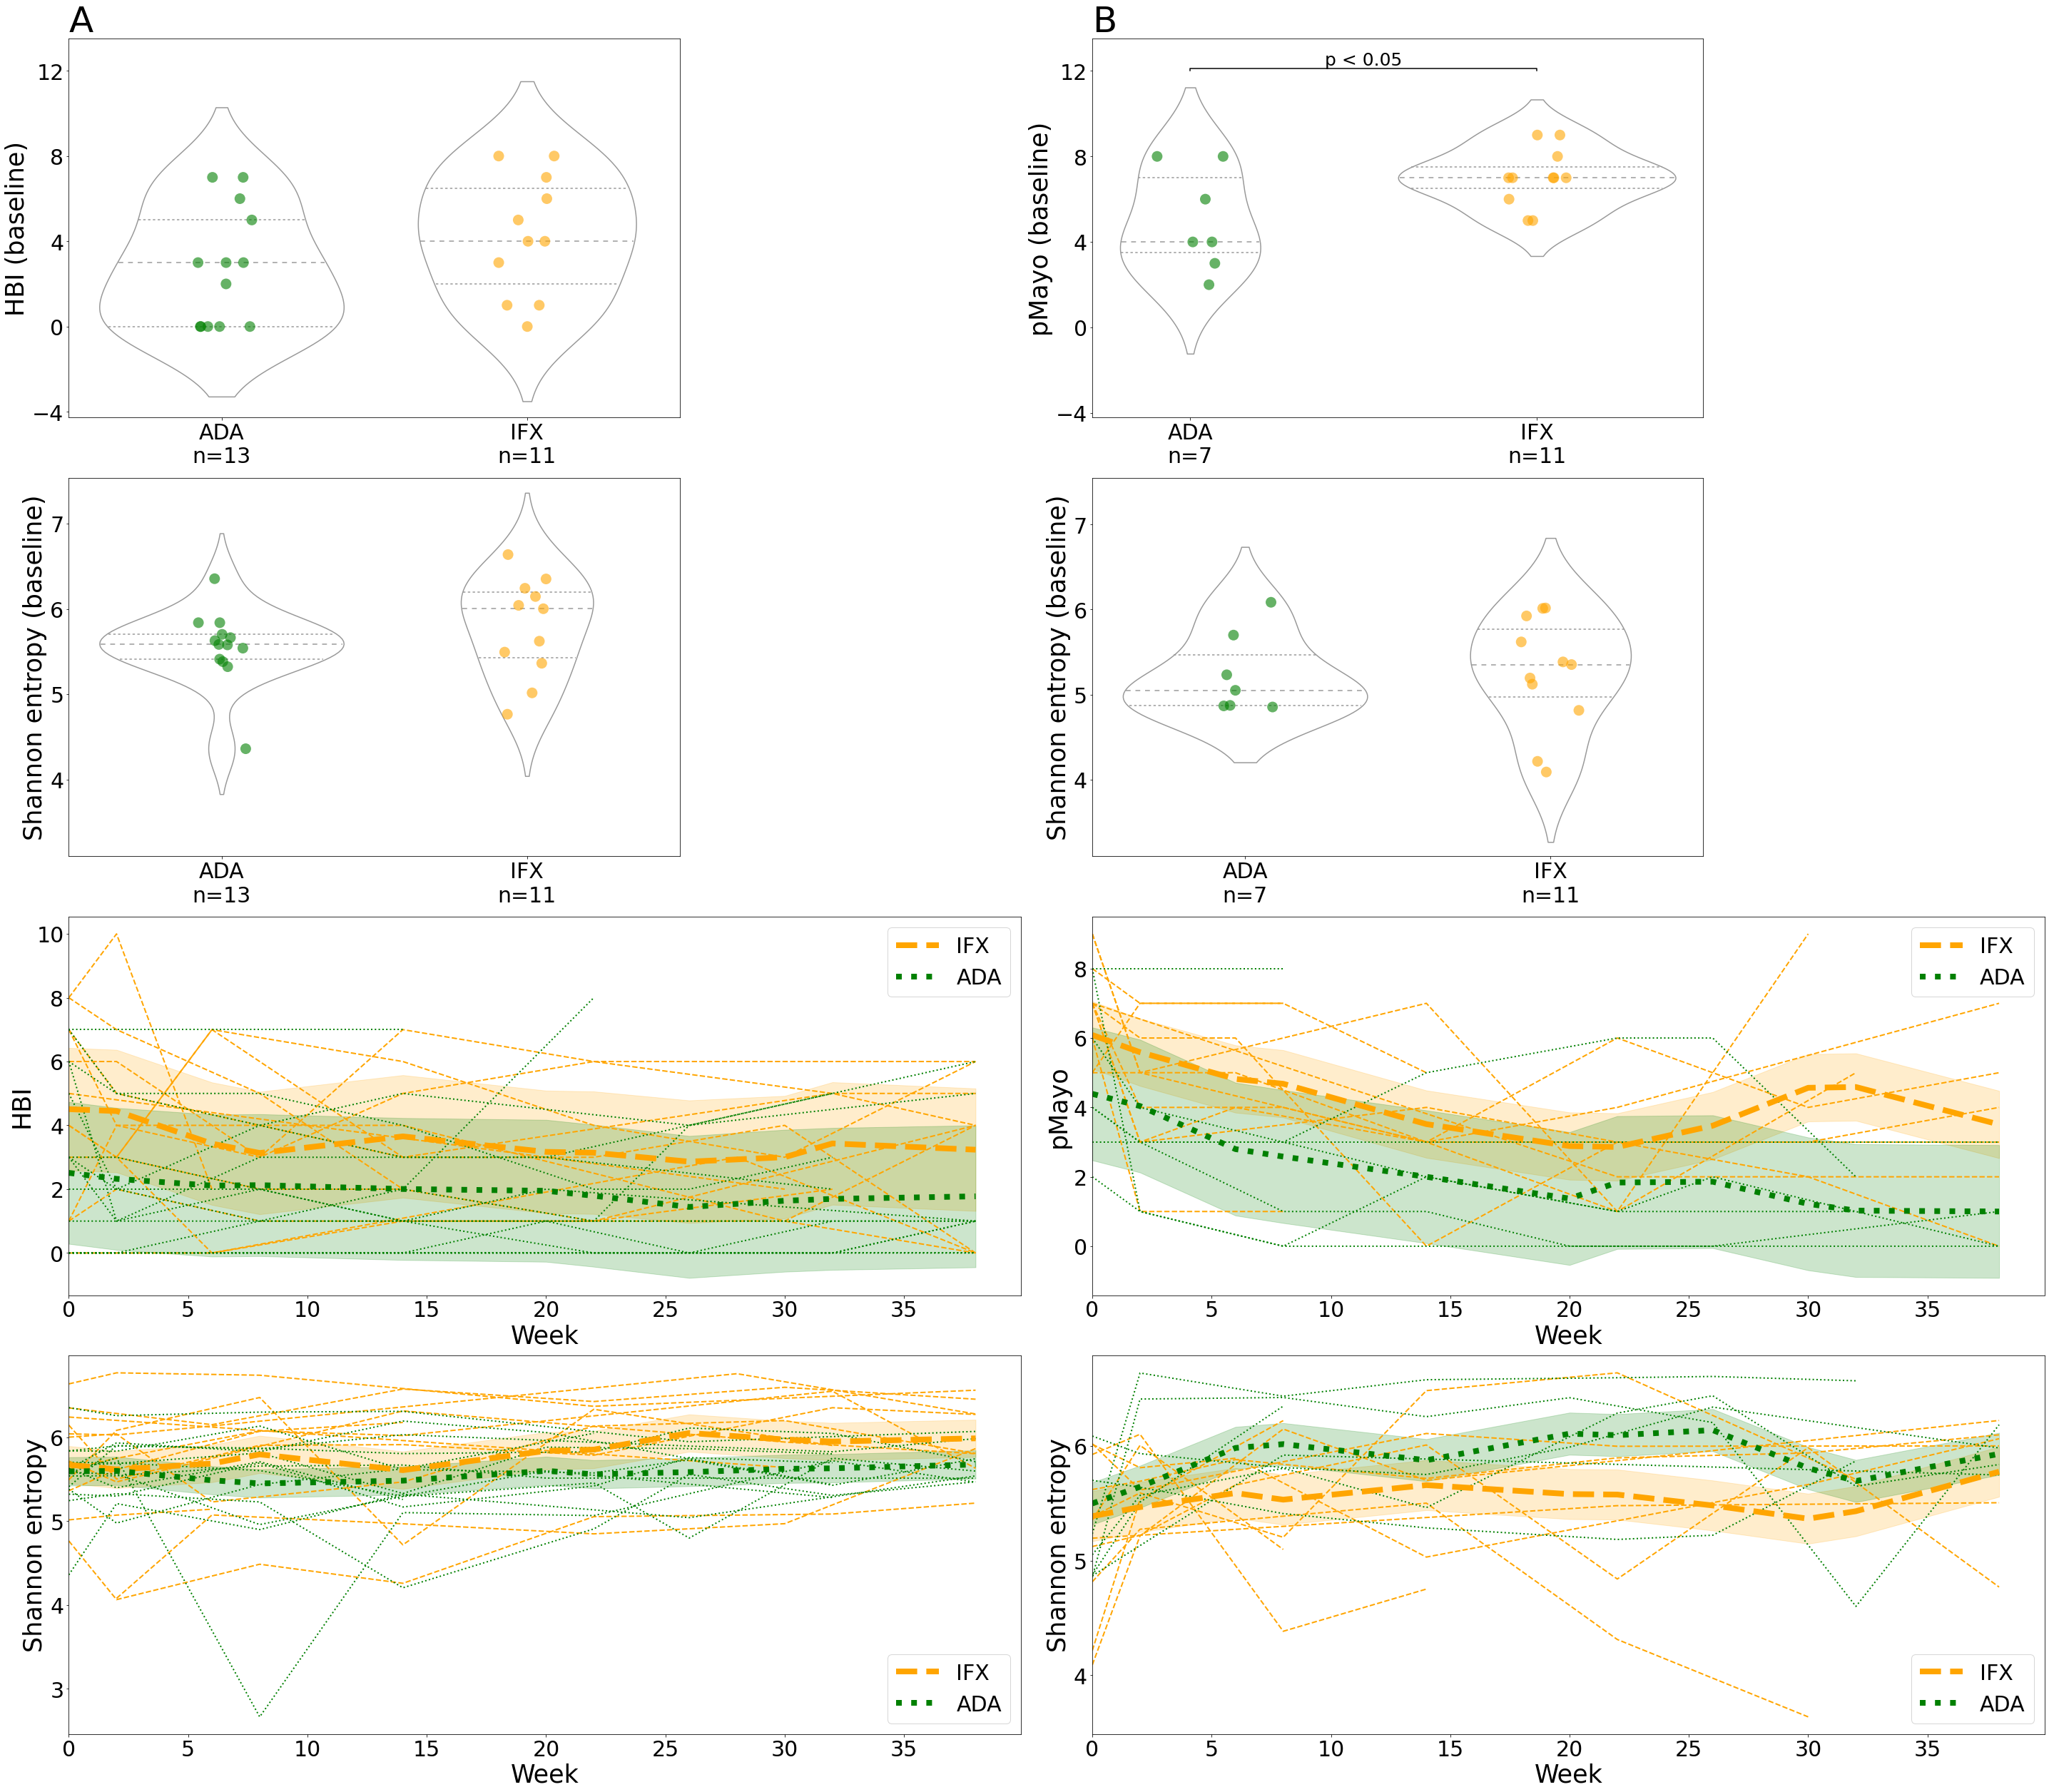

In [24]:
# create grid for subplots
fig2 = plt.figure()
fig2.set_figheight(35)
fig2.set_figwidth(40)

ax1 = plt.subplot2grid(shape=(4, 6), loc=(2, 0), colspan=3)
ax2 = plt.subplot2grid(shape=(4, 6), loc=(2, 3), colspan=3)
ax3 = plt.subplot2grid(shape=(4, 6), loc=(3, 0), colspan=3)
ax4 = plt.subplot2grid(shape=(4, 6), loc=(3, 3), colspan=3)
ax5 = plt.subplot2grid(shape=(4, 6), loc=(0, 0), colspan=2)
ax6 = plt.subplot2grid(shape=(4, 6), loc=(0, 3), colspan=2)
ax7 = plt.subplot2grid(shape=(4, 6), loc=(1, 0), colspan=2)
ax8 = plt.subplot2grid(shape=(4, 6), loc=(1, 3), colspan=2)

## timelines ##

# plot all CD patients including mean line
for individual in patients_cd_ifx.keys():
    ax1.plot(patients_cd_ifx[individual]["Week_num"], patients_cd_ifx[individual]["HBI_num"], linewidth=2, color = 'orange', linestyle='--')
for individual in patients_cd_ada.keys():
    ax1.plot(patients_cd_ada[individual]["Week_num"], patients_cd_ada[individual]["HBI_num"], linewidth=2, color = 'green', linestyle=':')
ax1.plot(pred_lowess_cd_hbi_ifx["Week_pred"], pred_lowess_cd_hbi_ifx["HBI_pred_lowess"], linewidth=8, color='orange', label='IFX', linestyle='--')
ax1.plot(pred_lowess_cd_hbi_ada["Week_pred"], pred_lowess_cd_hbi_ada["HBI_pred_lowess"], linewidth=8, color='green', label='ADA', linestyle=':')
ax1.fill_between(pred_lowess_cd_hbi_ifx["Week_pred"], (pred_lowess_cd_hbi_ifx["HBI_pred_lowess"]-ci_cd_hbi_ifx), (pred_lowess_cd_hbi_ifx["HBI_pred_lowess"]+ci_cd_hbi_ifx), color='orange', alpha=.2)
ax1.fill_between(pred_lowess_cd_hbi_ada["Week_pred"], (pred_lowess_cd_hbi_ada["HBI_pred_lowess"]-ci_cd_hbi_ada), (pred_lowess_cd_hbi_ada["HBI_pred_lowess"]+ci_cd_hbi_ada), color='green', alpha=.2)
ax1.set_xlim(xmin=0)
ax1.legend(loc=1, prop={'size': 30})
ax1.set_ylabel('HBI', fontsize=35)
ax1.set_xlabel('Week', fontsize=35)
ax1.tick_params(axis='both', labelsize=30)

# plot all UC patients including mean line
for individual in patients_uc_ifx.keys():
    ax2.plot(patients_uc_ifx[individual]["Week_num"], patients_uc_ifx[individual]["pMayo_num"], linewidth=2, color = 'orange', linestyle='--')
for individual in patients_uc_ada.keys():
    ax2.plot(patients_uc_ada[individual]["Week_num"], patients_uc_ada[individual]["pMayo_num"], linewidth=2, color = 'green', linestyle=':')
ax2.plot(pred_lowess_uc_pmayo_ifx["Week_pred"], pred_lowess_uc_pmayo_ifx["pMayo_pred_lowess"], linewidth=8, color='orange', label='IFX', linestyle='--')
ax2.plot(pred_lowess_uc_pmayo_ada["Week_pred"], pred_lowess_uc_pmayo_ada["pMayo_pred_lowess"], linewidth=8, color='green', label='ADA', linestyle=':')
ax2.fill_between(pred_lowess_uc_pmayo_ifx["Week_pred"], (pred_lowess_uc_pmayo_ifx["pMayo_pred_lowess"]-ci_uc_pmayo_ifx), (pred_lowess_uc_pmayo_ifx["pMayo_pred_lowess"]+ci_uc_pmayo_ifx), color='orange', alpha=.2)
ax2.fill_between(pred_lowess_uc_pmayo_ada["Week_pred"], (pred_lowess_uc_pmayo_ada["pMayo_pred_lowess"]-ci_uc_pmayo_ada), (pred_lowess_uc_pmayo_ada["pMayo_pred_lowess"]+ci_uc_pmayo_ada), color='green', alpha=.2)
ax2.set_xlim(xmin=0)
ax2.legend(loc=1, prop={'size': 30})
ax2.set_ylabel('pMayo', fontsize=35)
ax2.set_xlabel('Week', fontsize=35)
ax2.tick_params(axis='both', labelsize=30)



# plot all CD patients including mean line
for individual in patients_cd_ifx.keys():
    ax3.plot(patients_cd_ifx[individual]["Week_num"], patients_cd_ifx[individual]["Shannon_entropy"], linewidth=2, color = 'orange', linestyle='--')
for individual in patients_cd_ada.keys():
    ax3.plot(patients_cd_ada[individual]["Week_num"], patients_cd_ada[individual]["Shannon_entropy"], linewidth=2, color = 'green', linestyle=':')
ax3.plot(pred_lowess_cd_shannon_ada["Week_pred"], pred_lowess_cd_shannon_ifx["Shannon_pred_lowess"], linewidth=8, color='orange', label='IFX', linestyle='--')
ax3.plot(pred_lowess_cd_shannon_ifx["Week_pred"], pred_lowess_cd_shannon_ada["Shannon_pred_lowess"], linewidth=8, color='green', label='ADA', linestyle=':')
ax3.fill_between(pred_lowess_cd_shannon_ada["Week_pred"], (pred_lowess_cd_shannon_ifx["Shannon_pred_lowess"]-ci_cd_shannon_ifx), (pred_lowess_cd_shannon_ifx["Shannon_pred_lowess"]+ci_cd_shannon_ifx), color='orange', alpha=.2)
ax3.fill_between(pred_lowess_cd_shannon_ifx["Week_pred"], (pred_lowess_cd_shannon_ada["Shannon_pred_lowess"]-ci_cd_shannon_ada), (pred_lowess_cd_shannon_ada["Shannon_pred_lowess"]+ci_cd_shannon_ada), color='green', alpha=.2)
ax3.set_xlim(xmin=0)
ax3.legend(loc=4, prop={'size': 30})
ax3.set_ylabel('Shannon entropy', fontsize=35)
ax3.set_xlabel('Week', fontsize=35)
ax3.tick_params(axis='both', labelsize=30)

# plot all UC patients including mean line
for individual in patients_uc_ifx.keys():
    ax4.plot(patients_uc_ifx[individual]["Week_num"], patients_uc_ifx[individual]["Shannon_entropy"], linewidth=2, color = 'orange', linestyle='--')
for individual in patients_uc_ada.keys():
    ax4.plot(patients_uc_ada[individual]["Week_num"], patients_uc_ada[individual]["Shannon_entropy"], linewidth=2, color = 'green', linestyle=':')
ax4.plot(pred_lowess_uc_shannon_ifx["Week_pred"], pred_lowess_uc_shannon_ifx["Shannon_pred_lowess"], linewidth=8, color='orange', label='IFX', linestyle='--')
ax4.plot(pred_lowess_uc_shannon_ada["Week_pred"], pred_lowess_uc_shannon_ada["Shannon_pred_lowess"], linewidth=8, color='green', label='ADA', linestyle=':')
ax4.fill_between(pred_lowess_uc_shannon_ifx["Week_pred"], (pred_lowess_uc_shannon_ifx["Shannon_pred_lowess"]-ci_uc_shannon_ifx), (pred_lowess_uc_shannon_ifx["Shannon_pred_lowess"]+ci_uc_shannon_ifx), color='orange', alpha=.2)
ax4.fill_between(pred_lowess_uc_shannon_ada["Week_pred"], (pred_lowess_uc_shannon_ada["Shannon_pred_lowess"]-ci_uc_shannon_ada), (pred_lowess_uc_shannon_ada["Shannon_pred_lowess"]+ci_uc_shannon_ada), color='green', alpha=.2)
ax4.set_xlim(xmin=0)
ax4.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax4.legend(loc=4, prop={'size': 30})
ax4.set_ylabel('Shannon entropy', fontsize=35)
ax4.set_xlabel('Week', fontsize=35)
ax4.tick_params(axis='both', labelsize=30)


## violin plots ##
sns.violinplot(ax=ax5, data=cd_bsln, x='Drug', y='HBI_num', color='white', showfliers=False, inner='quartile')
sns.stripplot(ax=ax5, data=cd_bsln, x="Drug", y="HBI_num", size=15, alpha=.6, palette=["green","orange"])
ax5.set_ylim(ymax=13.5)
ax5.set_ylabel('HBI (baseline)', fontsize=35)
ax5.set_xlabel('')
ax5.set_xticklabels(["ADA\nn=13","IFX\nn=11"])
ax5.tick_params(axis='both', labelsize=30)
ax5.yaxis.set_major_locator(ticker.MultipleLocator(4))
ax5.set_title('A', fontsize=50, loc='left')

sns.violinplot(ax=ax6, data=uc_bsln, x='Drug', y='pMayo_num', color='white', showfliers=False, inner='quartile')
sns.stripplot(ax=ax6, data=uc_bsln, x="Drug", y="pMayo_num", size=15, alpha=.6, palette=["green","orange"])
ax6.set_ylim(ymin=-4.2, ymax=13.5)
ax6.set_ylabel('pMayo (baseline)', fontsize=35)
ax6.set_xlabel('')
ax6.set_xticklabels(["ADA\nn=7","IFX\nn=11"])
ax6.tick_params(axis='both', labelsize=30)
ax6.yaxis.set_major_locator(ticker.MultipleLocator(4))
ax6.set_title('B', fontsize=50, loc='left')

sns.violinplot(ax=ax7, data=cd_bsln, x='Drug', y='Shannon_entropy', color='white', showfliers=False, inner='quartile')
sns.stripplot(ax=ax7, data=cd_bsln, x="Drug", y="Shannon_entropy", size=15, alpha=.6, palette=["green","orange"])
ax7.set_ylim(ymin=3.1)
ax7.set_ylabel('Shannon entropy (baseline)', fontsize=35)
ax7.set_xlabel('')
ax7.set_xticklabels(["ADA\nn=13","IFX\nn=11"])
ax7.tick_params(axis='both', labelsize=30)

sns.violinplot(ax=ax8, data=uc_bsln, x='Drug', y='Shannon_entropy', color='white', showfliers=False, inner='quartile')
sns.stripplot(ax=ax8, data=uc_bsln, x="Drug", y="Shannon_entropy", size=15, alpha=.6, palette=["green","orange"])
ax8.set_ylim(ymin=3.1, ymax=7.55)
ax8.set_ylabel('Shannon entropy (baseline)', fontsize=35)
ax8.set_xlabel('')
ax8.set_xticklabels(["ADA\nn=7","IFX\nn=11"])
ax8.tick_params(axis='both', labelsize=30)

# statistical annotation
x1, x2 = 0, 1
y, h, col = uc_bsln['pMayo_num'].max() + 3, .1, 'k'
ax6.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax6.text((x1+x2)*.5, y+h, "p < 0.05", ha='center', va='bottom', color=col, fontsize=25)

plt.tight_layout()

# save fig
fig2.savefig('/Users/dagmarschierova/MEGA/MBÚ/TNF/NGS/runs_merged/outputs/qiime_results_B/diversity_Large_cohort/Clinical_scores_&_Shannon_drug_in_time-baseline.png')

